# Sparse Attention Demo: Baseline vs Hybrid Comparison

This notebook compares:
- **Baseline**: Standard transformer blocks (normal causal attention)
- **Hybrid**: Mix of standard + sparse hypergraph attention blocks

Adjust `n_standard_blocks` and `n_sparse_blocks` in the config cell to experiment.

Trained on a small WikiText-2 subset (~256K tokens).


In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict
import time
import gc

from model import ModelConfig, CausalLM
from data import Tokenizer, create_dataloaders

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")


Device: cuda
GPU: NVIDIA GeForce RTX 5090


## 1. Configuration


In [34]:
@dataclass
class TrainConfig:
    """Training config for demo."""
    batch_size: int = 4
    seq_len: int = 128
    lr: float = 3e-4
    num_steps: int = 500    # ~256K tokens
    log_every: int = 25
    eval_every: int = 100

cfg = TrainConfig()

# ============== ADJUST THESE ==============
baseline_config = ModelConfig(
    vocab_size=50257,
    dim=512,
    num_heads=8,
    n_standard_blocks=8,  # All standard
    n_sparse_blocks=0,
    max_seq_len=cfg.seq_len,
)

hybrid_config = ModelConfig(
    vocab_size=50257,
    dim=512,
    num_heads=8,
    n_standard_blocks=4,  # <-- Adjust here
    n_sparse_blocks=4,    # <-- Adjust here
    num_hyper_nodes=4,
    max_seq_len=cfg.seq_len,
)
# ==========================================

# Dynamic labels
def get_label(c):
    if c.n_sparse_blocks == 0:
        return f"{c.n_standard_blocks} standard"
    elif c.n_standard_blocks == 0:
        return f"{c.n_sparse_blocks} sparse"
    return f"{c.n_standard_blocks} std + {c.n_sparse_blocks} sparse"

BASELINE_LABEL = get_label(baseline_config)
HYBRID_LABEL = get_label(hybrid_config)

print(f"Baseline: {BASELINE_LABEL}")
print(f"Hybrid:   {HYBRID_LABEL}")


Baseline: 8 standard
Hybrid:   4 std + 4 sparse


## 2. Load Data


In [35]:
tokenizer = Tokenizer(max_length=cfg.seq_len)

loaders = create_dataloaders(
    tokenizer,
    dataset_name="wikitext-2",
    max_length=cfg.seq_len,
    batch_size=cfg.batch_size,
    num_workers=0,
    max_train_samples=2000,  # ~256K tokens
    max_eval_samples=100,
)

print(f"Train batches: {len(loaders['train'])}")
print(f"Val batches: {len(loaders['val'])}")
print(f"Total tokens: ~{len(loaders['train']) * cfg.batch_size * cfg.seq_len:,}")


Train batches: 500
Val batches: 25
Total tokens: ~256,000


## 3. Training Function


In [36]:
def train_model(model_config: ModelConfig, name: str) -> Dict:
    """Train model and return history."""
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print(f"{'='*50}")
    
    model = CausalLM(model_config).to(device)
    print(f"Parameters: {model.num_parameters():,}")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
    
    history = {"step": [], "train_loss": [], "val_loss": []}
    
    model.train()
    step = 0
    running_loss = 0.0
    start_time = time.time()
    
    for epoch in range(3):
        for batch in loaders["train"]:
            if step >= cfg.num_steps:
                break
            
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            running_loss += loss.item()
            step += 1
            
            if step % cfg.log_every == 0:
                avg_loss = running_loss / cfg.log_every
                print(f"  step {step:3d} | loss: {avg_loss:.4f} | time: {time.time()-start_time:.1f}s")
                history["step"].append(step)
                history["train_loss"].append(avg_loss)
                running_loss = 0.0
            
            if step % cfg.eval_every == 0:
                model.eval()
                val_loss = sum(
                    F.cross_entropy(
                        model(b["input_ids"].to(device)).view(-1, model_config.vocab_size),
                        b["labels"].to(device).view(-1)
                    ).item() for b in loaders["val"]
                ) / len(loaders["val"])
                history["val_loss"].append(val_loss)
                print(f"  >>> val_loss: {val_loss:.4f}")
                model.train()
        
        if step >= cfg.num_steps:
            break
    
    history["total_time"] = time.time() - start_time
    print(f"\nDone in {history['total_time']:.1f}s | Final loss: {history['train_loss'][-1]:.4f}")
    
    del model, optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    return history


## 4. Train Both Models


In [37]:
# Train both models
baseline_history = train_model(baseline_config, f"Baseline ({BASELINE_LABEL})")
hybrid_history = train_model(hybrid_config, f"Hybrid ({HYBRID_LABEL})")



Training: Baseline (8 standard)
Parameters: 50,902,016
  step  25 | loss: 9.0693 | time: 0.6s
  step  50 | loss: 7.1106 | time: 1.3s
  step  75 | loss: 6.7695 | time: 1.9s
  step 100 | loss: 6.6726 | time: 2.5s
  >>> val_loss: 6.1740
  step 125 | loss: 6.4414 | time: 3.3s
  step 150 | loss: 6.3524 | time: 3.9s
  step 175 | loss: 6.3332 | time: 4.5s
  step 200 | loss: 6.2785 | time: 5.2s
  >>> val_loss: 5.9322
  step 225 | loss: 6.2292 | time: 6.0s
  step 250 | loss: 6.2225 | time: 6.6s
  step 275 | loss: 6.1180 | time: 7.2s
  step 300 | loss: 6.1219 | time: 7.8s
  >>> val_loss: 5.7800
  step 325 | loss: 6.1214 | time: 8.6s
  step 350 | loss: 5.9507 | time: 9.2s
  step 375 | loss: 5.9192 | time: 9.8s
  step 400 | loss: 5.8096 | time: 10.5s
  >>> val_loss: 5.6522
  step 425 | loss: 5.9083 | time: 11.3s
  step 450 | loss: 5.8619 | time: 11.9s
  step 475 | loss: 5.8954 | time: 12.5s
  step 500 | loss: 5.8371 | time: 13.1s
  >>> val_loss: 5.6000

Done in 13.3s | Final loss: 5.8371

Trainin

## 5. Plot Loss Curves


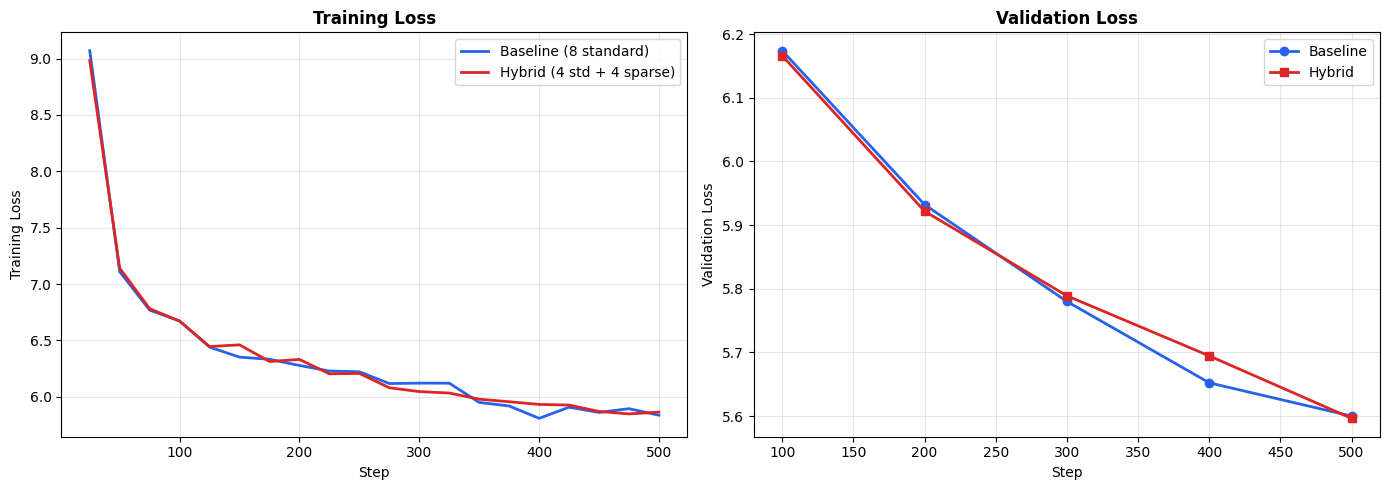

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
ax1 = axes[0]
ax1.plot(baseline_history["step"], baseline_history["train_loss"], 
         label=f"Baseline ({BASELINE_LABEL})", color="#2563eb", linewidth=2)
ax1.plot(hybrid_history["step"], hybrid_history["train_loss"], 
         label=f"Hybrid ({HYBRID_LABEL})", color="#dc2626", linewidth=2)
ax1.set_xlabel("Step")
ax1.set_ylabel("Training Loss")
ax1.set_title("Training Loss", fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Loss
ax2 = axes[1]
val_steps = [s for s in baseline_history["step"] if s % cfg.eval_every == 0]
ax2.plot(val_steps[:len(baseline_history["val_loss"])], baseline_history["val_loss"], 
         'o-', label="Baseline", color="#2563eb", linewidth=2)
ax2.plot(val_steps[:len(hybrid_history["val_loss"])], hybrid_history["val_loss"], 
         's-', label="Hybrid", color="#dc2626", linewidth=2)
ax2.set_xlabel("Step")
ax2.set_ylabel("Validation Loss")
ax2.set_title("Validation Loss", fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("loss_comparison.png", dpi=150)
plt.show()


## 6. Measure Inference & Memory


In [39]:
def measure_inference(model_config, num_runs=10):
    """Measure inference time and memory."""
    model = CausalLM(model_config).to(device).eval()
    x = torch.randint(0, 1000, (1, cfg.seq_len), device=device)
    
    # Warmup
    for _ in range(3):
        with torch.no_grad():
            _ = model(x)
    
    # Measure time
    torch.cuda.synchronize()
    times = []
    for _ in range(num_runs):
        torch.cuda.synchronize()
        t0 = time.perf_counter()
        with torch.no_grad():
            _ = model(x)
        torch.cuda.synchronize()
        times.append(time.perf_counter() - t0)
    
    # Measure memory
    torch.cuda.reset_peak_memory_stats()
    with torch.no_grad():
        _ = model(x)
    peak_mem = torch.cuda.max_memory_allocated() / 1024**2
    
    result = {
        "time_ms": sum(times) / len(times) * 1000,
        "memory_mb": peak_mem,
    }
    
    del model
    torch.cuda.empty_cache()
    return result

baseline_perf = measure_inference(baseline_config)
hybrid_perf = measure_inference(hybrid_config)

print(f"Baseline: {baseline_perf['time_ms']:.2f}ms, {baseline_perf['memory_mb']:.1f}MB")
print(f"Hybrid:   {hybrid_perf['time_ms']:.2f}ms, {hybrid_perf['memory_mb']:.1f}MB")


Baseline: 5.43ms, 260.3MB
Hybrid:   82.47ms, 260.5MB


## 7. Summary


In [40]:
print("=" * 65)
print("COMPARISON SUMMARY")
print("=" * 65)
print(f"{'Metric':<28} {'Baseline':<17} {'Hybrid':<17}")
print("-" * 65)
print(f"{'Architecture':<28} {BASELINE_LABEL:<17} {HYBRID_LABEL:<17}")
print(f"{'Training Time (s)':<28} {baseline_history['total_time']:<17.1f} {hybrid_history['total_time']:<17.1f}")
print(f"{'Final Train Loss':<28} {baseline_history['train_loss'][-1]:<17.4f} {hybrid_history['train_loss'][-1]:<17.4f}")
print(f"{'Final Val Loss':<28} {baseline_history['val_loss'][-1]:<17.4f} {hybrid_history['val_loss'][-1]:<17.4f}")
print("-" * 65)
print(f"{'Inference Time (ms)':<28} {baseline_perf['time_ms']:<17.2f} {hybrid_perf['time_ms']:<17.2f}")
print(f"{'Peak Memory (MB)':<28} {baseline_perf['memory_mb']:<17.1f} {hybrid_perf['memory_mb']:<17.1f}")

# Compute differences
time_diff = (hybrid_perf['time_ms'] - baseline_perf['time_ms']) / baseline_perf['time_ms'] * 100
mem_diff = (hybrid_perf['memory_mb'] - baseline_perf['memory_mb']) / baseline_perf['memory_mb'] * 100
train_diff = (hybrid_history['total_time'] - baseline_history['total_time']) / baseline_history['total_time'] * 100

print("-" * 65)
print(f"{'Inference Time Change':<28} {'':<17} {time_diff:+.1f}%")
print(f"{'Memory Change':<28} {'':<17} {mem_diff:+.1f}%")
print(f"{'Training Time Change':<28} {'':<17} {train_diff:+.1f}%")
print("=" * 65)

# KV-Cache theoretical analysis
print("\nKV-Cache Analysis (theoretical):")
K = hybrid_config.num_hyper_nodes
reduction = (hybrid_config.n_sparse_blocks / hybrid_config.depth) * (1 - 1/K)
print(f"  Sparse layers reduce KV by 1/{K} (K={K} hypernodes)")
print(f"  With {hybrid_config.n_sparse_blocks}/{hybrid_config.depth} sparse layers:")
print(f"  Theoretical KV reduction: ~{reduction*100:.1f}%")


COMPARISON SUMMARY
Metric                       Baseline          Hybrid           
-----------------------------------------------------------------
Architecture                 8 standard        4 std + 4 sparse 
Training Time (s)            13.3              62.3             
Final Train Loss             5.8371            5.8647           
Final Val Loss               5.6000            5.5964           
-----------------------------------------------------------------
Inference Time (ms)          5.43              82.47            
Peak Memory (MB)             260.3             260.5            
-----------------------------------------------------------------
Inference Time Change                          +1418.7%
Memory Change                                  +0.1%
Training Time Change                           +368.5%

KV-Cache Analysis (theoretical):
  Sparse layers reduce KV by 1/4 (K=4 hypernodes)
  With 4/8 sparse layers:
  Theoretical KV reduction: ~37.5%
